In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from scipy import stats

import plotly.io as pio
pio.renderers.default = "png"
pd.set_option('display.max_columns', None)

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

from sklearn.model_selection import train_test_split

from statsmodels import api as sm

from functions import df_engineered

In [2]:
df = pd.read_csv('data/Ames_Housing_Price_Data.csv', index_col=0).iloc[:,1:]
print('df shape:', df.shape)

data = df_engineered(df)

df shape: (2580, 80)


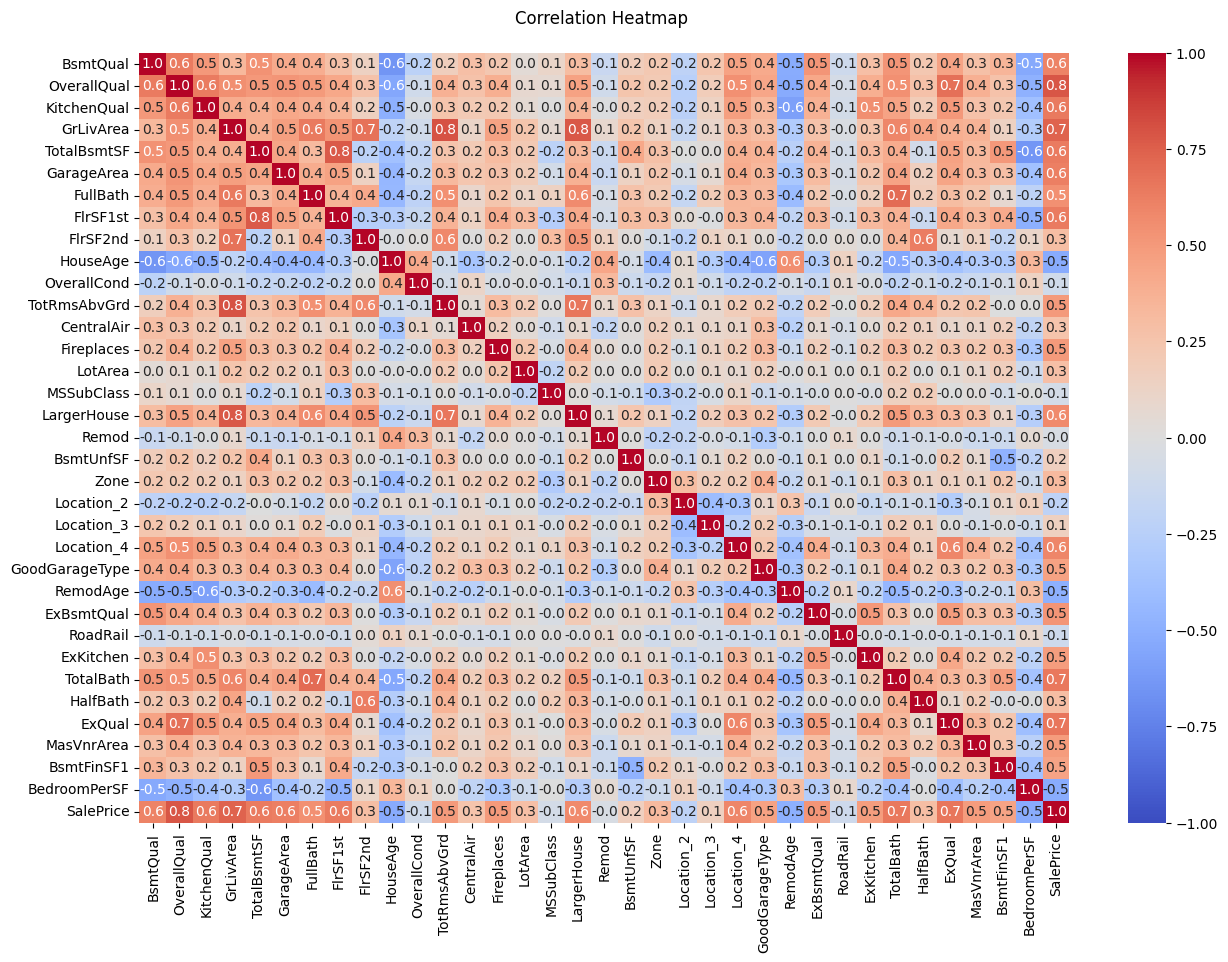

In [3]:
feature_selection = ['BsmtQual' , 'OverallQual' , 'KitchenQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea' , 'FullBath' , 'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'LargerHouse' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location_2', 'Location_3' , 'Location_4' , 'GoodGarageType',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'ExKitchen' , 'TotalBath', 
                    'HalfBath', 'ExQual', 
                    'MasVnrArea', 'BsmtFinSF1', 'BedroomPerSF']

plt.figure(figsize=(15, 10))

corr_mat = data[feature_selection + ['SalePrice']].corr()

sns.heatmap(corr_mat,
            annot=True,
            fmt='.1f',
            vmin=-1,
            vmax=1,
            cmap='coolwarm'
            )
title = plt.title('Correlation Heatmap \n')

In [4]:
skewness = data[feature_selection].skew().sort_values(ascending=False)
print(skewness[abs(skewness) > 0.75])
skewed_cols = list(skewness[abs(skewness) > 0.75].index)

data['LotArea'] = np.log(data['LotArea'])

LotArea         13.647537
ExKitchen        4.212534
RoadRail         3.690437
ExBsmtQual       3.571738
MasVnrArea       2.740317
ExQual           2.079905
Location_4       1.821239
Location_3       1.405190
MSSubClass       1.339800
FlrSF1st         1.045575
BsmtUnfSF        0.981279
GrLivArea        0.943880
FlrSF2nd         0.804334
BedroomPerSF     0.767331
Zone            -1.733407
CentralAir      -3.705920
dtype: float64


In [5]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns='SalePrice'), data[['SalePrice']], test_size=0.30, random_state=42)

# Model

### Standardization

In [6]:
scaler = StandardScaler()

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

y_train = np.log(y_train.reset_index(drop=True)['SalePrice'])
y_test = np.log(y_test.reset_index(drop=True)['SalePrice'])

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train[feature_selection]), columns=X_train[feature_selection].columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test[feature_selection]), columns=X_test[feature_selection].columns)

## Linear Regression

In [7]:
ols = LinearRegression()
ols.fit(X_train_scaled, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ols, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ols, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9278 0.9285 0.9335 0.9319 0.9497]
Mean shuffled cross validation score: 0.9343
RMSE Shuffled cross validation score: [0.0946 0.0989 0.0904 0.0977 0.0822]
RMSE Mean shuffled cross validation score: 0.0928


In [8]:
test_score = ols.score(X_test_scaled, y_test)

print('Test score:', np.round(test_score, 4))

rms = mean_squared_error(y_test, ols.predict(X_test_scaled), squared=False)
print('RMSE Test score:', np.round(rms, 4))

Test score: 0.9327
RMSE Test score: 0.0971


In [9]:
yhat_train = ols.predict(X_train_scaled)
yhat_test = ols.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16379.594225488596
16893.76521274549


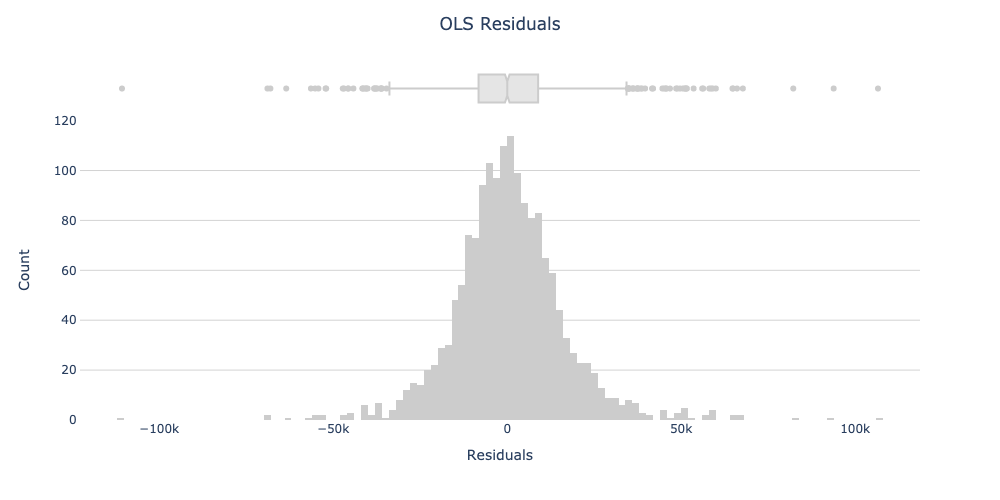

In [10]:
yhat = ols.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                pd.concat([X_train, np.exp(y_train)], axis=1), 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])

#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='OLS Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

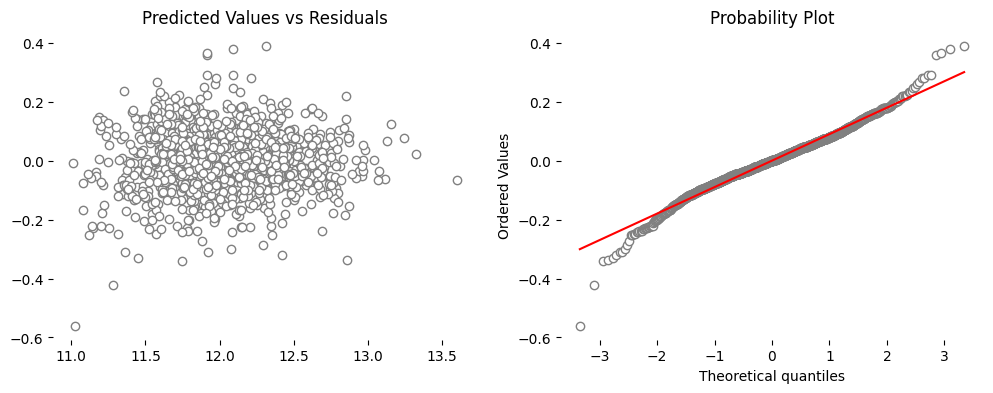

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [12]:
res = stats.shapiro(residuals)
res.statistic

0.9798510670661926

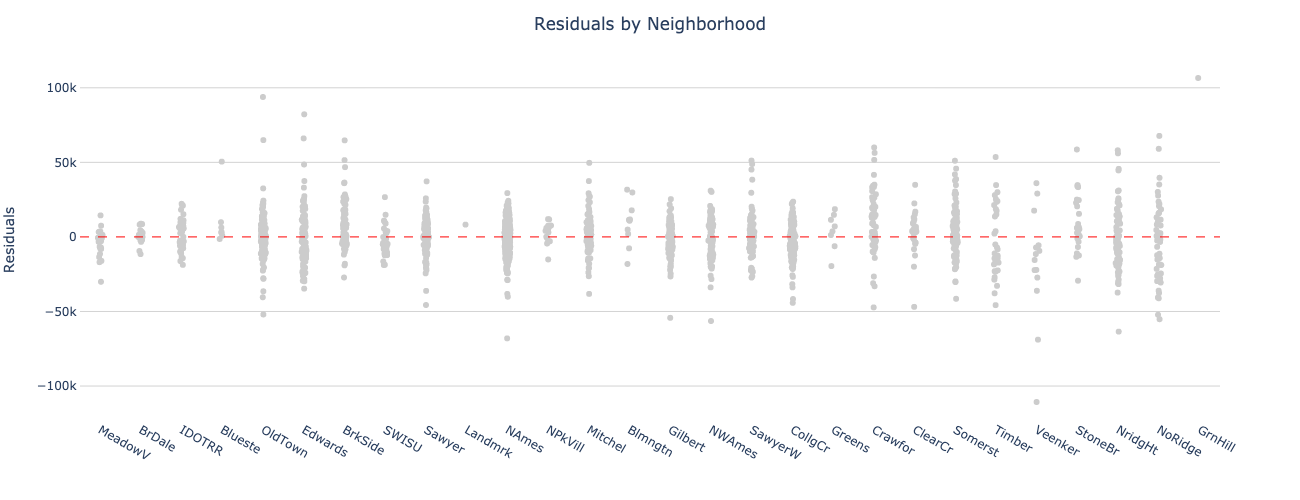

In [13]:
order = results.groupby('Neighborhood').SalePrice.median().sort_values().index

fig = px.strip(
            results, 
            x='Neighborhood', 
            y='residual',
            category_orders={'Neighborhood':order},
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by Neighborhood', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

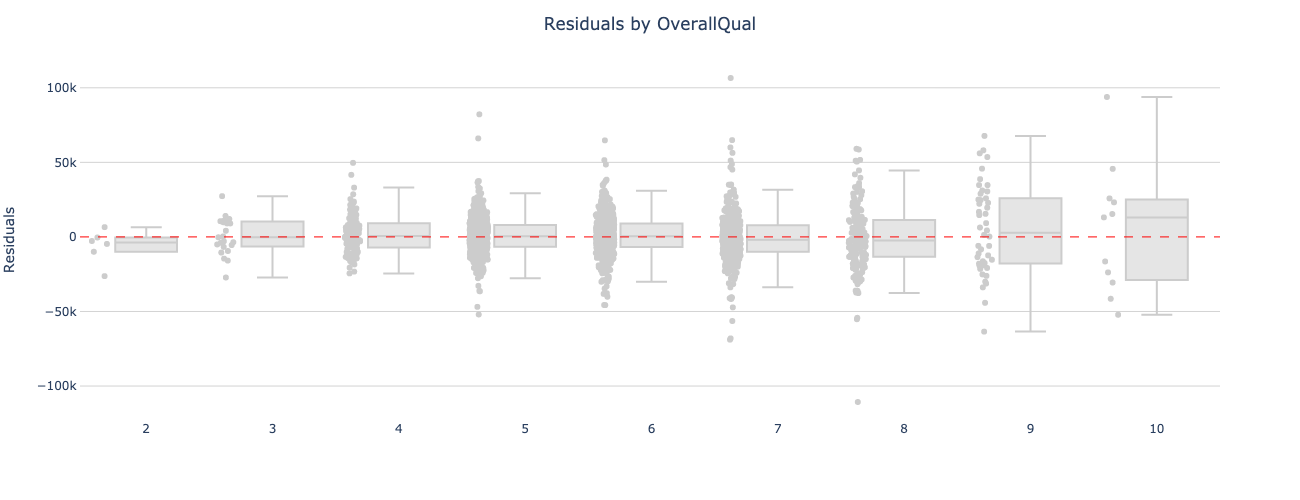

In [14]:
order = results.groupby('OverallQual').SalePrice.median().sort_values().index

fig = px.box(
            results, 
            x='OverallQual', 
            y='residual',
            category_orders={'OverallQual':order},
            points="all",
            width=1300)  

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
            title='Residuals by OverallQual', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')

fig.update_yaxes(
            showline=True,
            gridcolor='lightgray',
            title="Residuals")
            
fig.update_xaxes(
            title=None)

fig.add_hline(y=0, line_width=1, line_dash="dash", line_color="red")

fig.show()

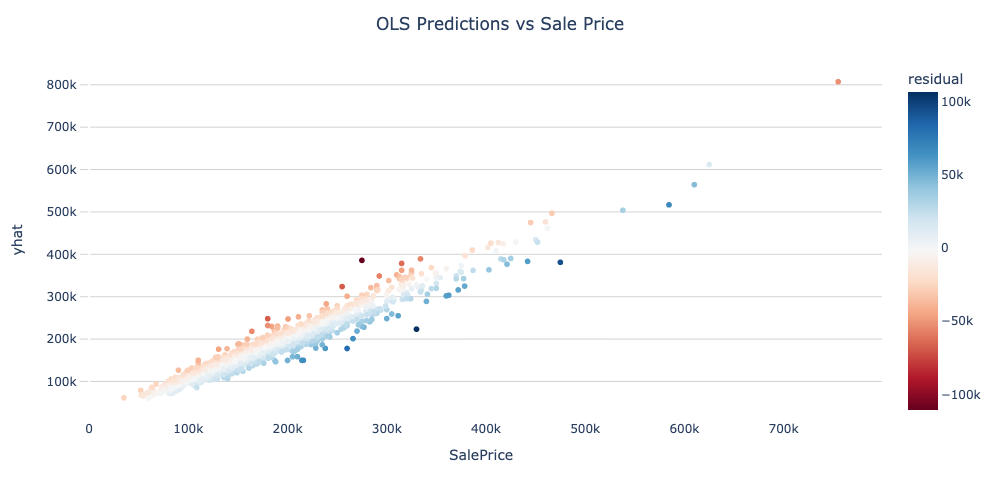

In [15]:
fig = px.scatter(
            results, 
            x='SalePrice', 
            y='yhat',
            color='residual',
            color_continuous_scale='RdBu',
            width=1000)

fig.update_layout(
            title='OLS Predictions vs Sale Price', title_x=0.5,
            showlegend=False,
            plot_bgcolor='white')
            
fig.update_yaxes(
            showline=True,
            gridcolor='lightgray')
            
fig.show()

## Lasso

In [16]:
lasso = LassoCV(cv=5)
lasso.fit(X_train_scaled, y_train)

best_alpha = lasso.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = lasso.predict(X_test_scaled)

# Calculate RMSE
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_lasso)


Best alpha: 0.0006849190422199476
RMSE: 0.09749560262776


In [17]:
kf = KFold(n_splits=2, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(lasso, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(lasso, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9309 0.9381]
Mean shuffled cross validation score: 0.9345
RMSE Shuffled cross validation score: [0.0952 0.0906]
RMSE Mean shuffled cross validation score: 0.0929


In [18]:
yhat_train = lasso.predict(X_train_scaled)
yhat_test = lasso.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16348.366241170657
16958.655503406793


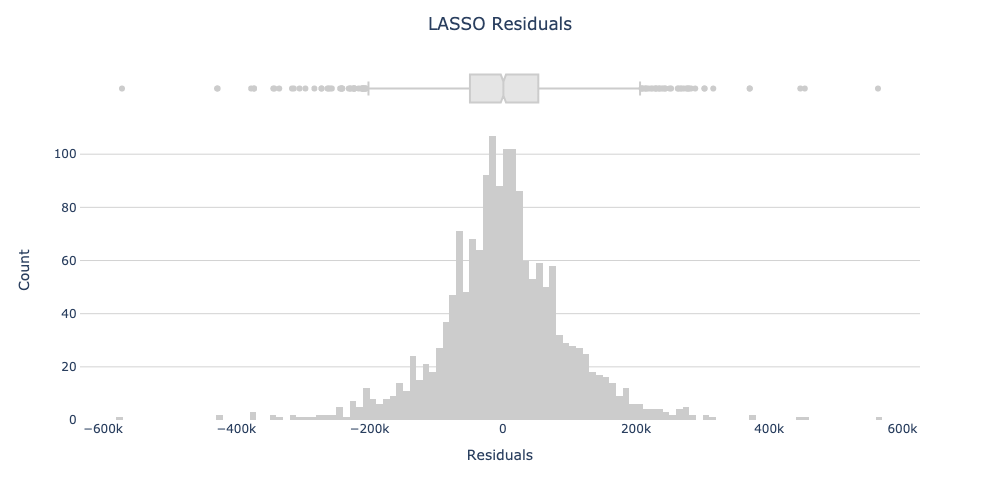

In [19]:
yhat = lasso.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='LASSO Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

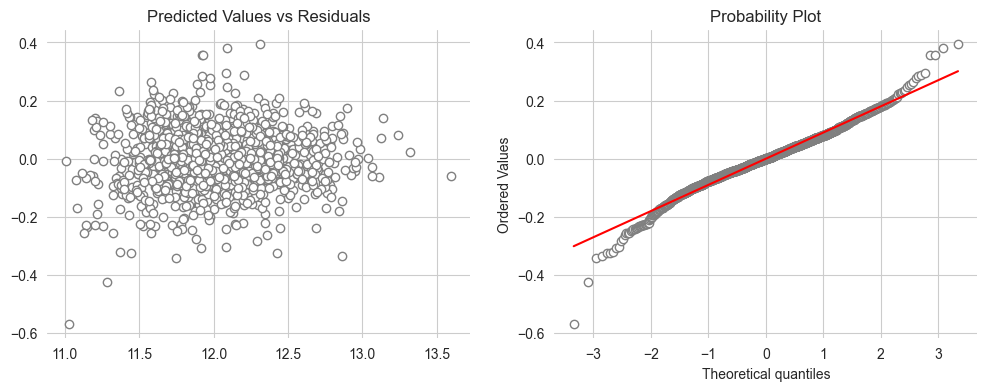

In [20]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [21]:
res = stats.shapiro(residuals)
res.statistic

0.9789933562278748

## Ridge

In [22]:
ridge = RidgeCV(cv=5)
ridge.fit(X_train_scaled, y_train)

best_alpha = ridge.alpha_
print('Best alpha:', best_alpha)

# Predict on the test set
y_pred = ridge.predict(X_test_scaled)

# Calculate RMSE
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse_ridge)


Best alpha: 10.0
RMSE: 0.09707478011650826


In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=10)
cv_scores_shuffled = cross_val_score(ridge, X_train_scaled, y_train, cv=kf)
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))
cv_results_RMSE = np.sqrt(-cross_val_score(ridge, X_train_scaled, y_train, scoring="neg_mean_squared_error", cv=kf))


print('Shuffled cross validation score:', np.round(cv_scores_shuffled, 4))
print('Mean shuffled cross validation score:', np.round(cv_scores_shuffled.mean(), 4))

print('RMSE Shuffled cross validation score:', np.round(cv_results_RMSE, 4))
print('RMSE Mean shuffled cross validation score:', np.round(cv_results_RMSE.mean(), 4))

Shuffled cross validation score: [0.9278 0.9286 0.9339 0.9323 0.9495]
Mean shuffled cross validation score: 0.9344
RMSE Shuffled cross validation score: [0.0946 0.0989 0.0901 0.0974 0.0824]
RMSE Mean shuffled cross validation score: 0.0927


In [24]:
yhat_train = ridge.predict(X_train_scaled)
yhat_test = ridge.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16374.126889965317
16899.82625977443


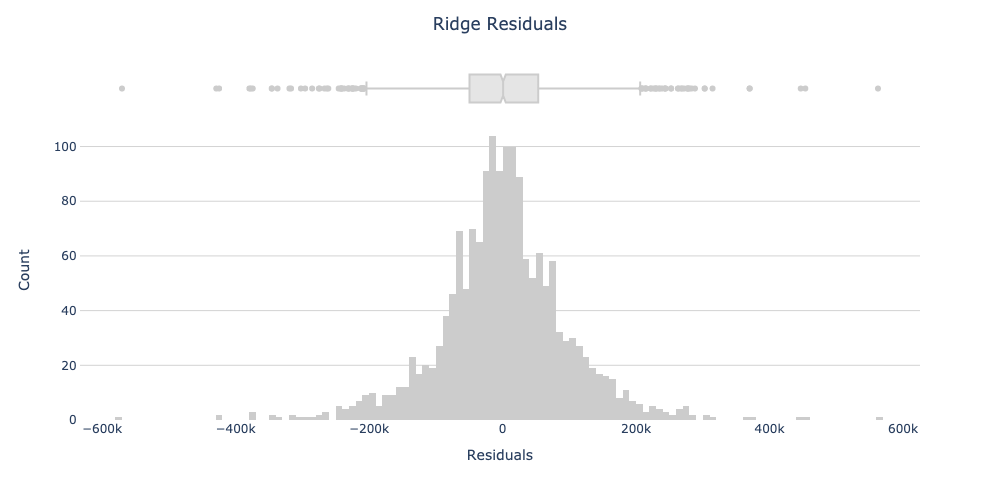

In [25]:
yhat = ridge.predict(X_train_scaled)
residuals = y_train - yhat

results = pd.concat([
                data, 
                pd.DataFrame(np.exp(yhat), columns=['yhat'])], 
                axis=1
                )

results['residual'] = (results['SalePrice'] - results['yhat'])


#Plot
fig = px.histogram(
                results, 
                x="residual",
                marginal="box",
                width=1000)

fig.update_traces(marker_color = '#cccccc')

fig.update_layout(
                title='Ridge Residuals', title_x=0.5,
                showlegend=False,
                plot_bgcolor='white')

fig.update_yaxes(
                showline=True,
                gridcolor='lightgray',
                title="Count",
                row=1, col=1)

fig.update_xaxes(
                title="Residuals",
                row=1, col=1)

fig.show()

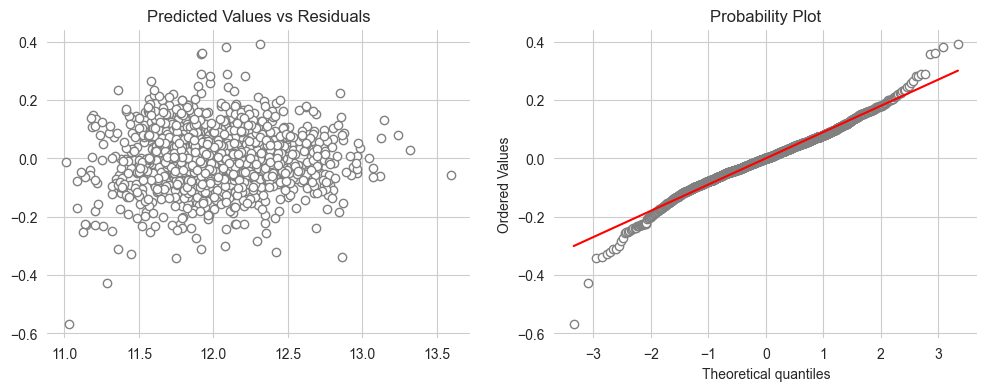

In [26]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(ncols=2, figsize=(12,4))
sns.despine(left=True, bottom=True)

ax[0].scatter(yhat, residuals, edgecolors='grey', color='white')
ax[0].title.set_text('Predicted Values vs Residuals')

stats.probplot(residuals, dist="norm", plot=plt)
ax[1].get_lines()[0].set_markeredgecolor('grey')
ax[1].get_lines()[0].set_markerfacecolor('white')

plt.show()

In [27]:
res = stats.shapiro(residuals)
res.statistic

0.9795404076576233

## Stats model

In [28]:
X_train_scaled_sm = sm.add_constant(X_train_scaled)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                    GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                    HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                    Fireplaces + LotArea + MSSubClass + Remod +\
                    BsmtUnfSF + Zone + Location_2 + Location_3 + Location_4 +\
                    RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                    MasVnrArea + BsmtFinSF1 +\
                    GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=1.1/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     823.4
Date:                Mon, 07 Aug 2023   Prob (F-statistic):               0.00
Time:                        23:59:40   Log-Likelihood:                 1644.4
No. Observations:                1678   AIC:                            -3227.
Df Residuals:                    1647   BIC:                            -3059.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.0174      0.002   4856.493      0.000      12.013      12.022
BsmtQual                 0.0069      0.004      1.603      0.109      -0.002       0.015
OverallQual              0.0847      0.004     20.785      0.000       0.077       0.093
GrLivArea                0.0718      0.025      2.925      0.003       0.024       0.120
TotalBsmtSF              0.0535      0.007      7.956      0.000       0.040       0.067
GarageArea               0.0254      0.003      8.554      0.000       0.020       0.031
FullBath                -0.0028      0.004     -0.782      0.434      -0.010       0.004
FlrSF1st                 0.0312      0.019      1.654      0.098      -0.006       0.068
FlrSF2nd                 0.0430      0.022      1.969      0.049       0.000       0.086
HouseAge                -0.0496      0.005     -9.555      0.000      -0.060      -0.039
OverallCond              0.0510      0.003     17.095      0.000       0.045       0.057
TotRmsAbvGrd             0.0015      0.005      0.335      0.737      -0.007       0.010
CentralAir               0.0190      0.003      7.341      0.000       0.014       0.024
Fireplaces               0.0226      0.003      8.236      0.000       0.017       0.028
LotArea                  0.0454      0.003     13.557      0.000       0.039       0.052
MSSubClass              -0.0016      0.003     -0.531      0.595      -0.008       0.004
Remod                   -0.0043      0.003     -1.479      0.139      -0.010       0.001
BsmtUnfSF               -0.0221      0.005     -4.149      0.000      -0.032      -0.012
Zone                     0.0134      0.003      4.031      0.000       0.007       0.020
Location_2               0.0056      0.004      1.383      0.167      -0.002       0.014
Location_3               0.0299      0.004      7.332      0.000       0.022       0.038
Location_4               0.0406      0.004      9.031      0.000       0.032       0.049
RemodAge                -0.0166      0.004     -4.550      0.000      -0.024      -0.009
ExBsmtQual               0.0109      0.003      3.582      0.000       0.005       0.017
RoadRail                -0.0106      0.002     -4.643      0.000      -0.015      -0.006
KitchenQual              0.0190      0.003      5.861      0.000       0.013       0.025
HalfBath                 0.0014      0.003      0.415      0.679      -0.005       0.008
BedroomPerSF            -0.0126      0.004     -3.511      0.000      -0.020      -0.006
MasVnrArea               0.0033      0.003      1.255      0.210      -0.002       0.009
BsmtFinSF1               0.0189      0.005      3.443      0.001       0.008       0.030
GrLivArea:Fireplaces    -0.0036      0.002     -1.490      0.136      -0.008       0.001
=========================================================

In [29]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(np.exp(y_train), np.exp(yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test), np.exp(yhat_test), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16408.226805518487
16993.86454262865


In [30]:
yhat_train = final.predict(X_train_scaled)
yhat_test = final.predict(X_test_scaled)

train_rmse_non_log = mean_squared_error(y_train, yhat_train, squared=False)
test_rmse_non_log = mean_squared_error(y_test, yhat_test, squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

0.09081843691289472
0.09736025445216465


## Interactions with Location

In [31]:
data = df_engineered(df, Reg=False)

In [32]:
temp = data[data.Location==4]
#temp = data[data.LargerHouse==0]

X_train_loc, X_test_loc, y_train_loc, y_test_loc = \
    train_test_split(temp.drop(columns='SalePrice'), temp[['SalePrice']], test_size=0.30, random_state=42)

### Standardization

In [33]:
feature_selection = ['BsmtQual' , 'OverallQual' ,
                    'GrLivArea' , 'TotalBsmtSF'  , 'GarageArea', 'FullBath' ,'FlrSF1st' , 'FlrSF2nd',
                    'HouseAge'  , 'OverallCond' , 'TotRmsAbvGrd' , 'CentralAir',
                    'Fireplaces' , 'LotArea' , 'MSSubClass' , 'Remod',
                    'BsmtUnfSF' , 'Zone' , 'Location',
                    'RemodAge' , 'ExBsmtQual' , 'RoadRail', 'KitchenQual' , 'HalfBath', 
                    'MasVnrArea', 'BsmtFinSF1', 'BedroomPerSF']

In [34]:
scaler = StandardScaler()

X_train_loc = X_train_loc.reset_index(drop=True)
X_test_loc = X_test_loc.reset_index(drop=True)

y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)

In [35]:
X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass + Remod +\
                        BsmtUnfSF + Zone + Location +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        MasVnrArea + BsmtFinSF1 +\
                        GrLivArea:Fireplaces', 
                    data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

results_fu = model.fit()

n = X_train.shape[0]
results_fr = model.fit_regularized(L1_wt=0, alpha=0/n, start_params=results_fu.params)

#test_params = np.insert(ridge.coef_, 0, ridge.intercept_, axis=0)
test_params = np.round(results_fr.params, 6)
test_params[0] = results_fu.params[0]

final = sm.regression.linear_model.OLSResults(model, 
                                              test_params,
                                              model.normalized_cov_params)

final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.935
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                     136.5
Date:                Mon, 07 Aug 2023   Prob (F-statistic):          6.00e-131
Time:                        23:59:40   Log-Likelihood:                 310.19
No. Observations:                 274   AIC:                            -566.4
Df Residuals:                     247   BIC:                            -468.8
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               12.4715      0.006   2257.086      0.000      12.461      12.482
BsmtQual                -0.0274      0.024     -1.143      0.254      -0.075       0.020
OverallQual              0.0755      0.009      8.677      0.000       0.058       0.093
GrLivArea               -0.4972      0.329     -1.511      0.132      -1.145       0.151
TotalBsmtSF              0.0646      0.020      3.305      0.001       0.026       0.103
GarageArea               0.0143      0.008      1.862      0.064      -0.001       0.029
FullBath                -0.0101      0.009     -1.161      0.247      -0.027       0.007
FlrSF1st                 0.5461      0.272      2.010      0.045       0.011       1.081
FlrSF2nd                 0.6618      0.333      1.985      0.048       0.005       1.319
HouseAge                -0.0601      0.023     -2.580      0.010      -0.106      -0.014
OverallCond              0.0254      0.010      2.522      0.012       0.006       0.045
TotRmsAbvGrd            -0.0153      0.011     -1.346      0.180      -0.038       0.007
CentralAir           -2.505e+13   1.05e-15  -2.38e+28      0.000    -2.5e+13    -2.5e+13
Fireplaces               0.0204      0.007      2.967      0.003       0.007       0.034
LotArea                  0.0267      0.006      4.207      0.000       0.014       0.039
MSSubClass              -0.0382      0.008     -4.796      0.000      -0.054      -0.023
Remod                    0.0075      0.006      1.305      0.193      -0.004       0.019
BsmtUnfSF               -0.0536      0.013     -4.013      0.000      -0.080      -0.027
Zone                    -0.0198      0.005     -3.836      0.000      -0.030      -0.010
Location             -5.392e+13   1.51e-16  -3.58e+29      0.000   -5.39e+13   -5.39e+13
RemodAge                -0.0023      0.018     -0.125      0.901      -0.038       0.034
ExBsmtQual               0.0340      0.022      1.536      0.126      -0.010       0.078
RoadRail                  2e-06      0.005      0.000      1.000      -0.010       0.010
KitchenQual              0.0239      0.008      3.153      0.002       0.009       0.039
HalfBath                 0.0096      0.010      0.913      0.362      -0.011       0.030
BedroomPerSF            -0.0117      0.010     -1.124      0.262      -0.032       0.009
MasVnrArea               0.0050      0.006      0.792      0.429      -0.007       0.017
BsmtFinSF1              -0.0081      0.015     -0.553      0.581      -0.037       0.021
GrLivArea:Fireplaces    -0.0081      0.005     -1.484      0.139      -0.019       0.003
==============================================================================
Omnibus:                        0.654   Durbin-Watson:                   1.729
Prob(Omnibus):                  0.721   Jarque-Bera (JB):                0.41

In [36]:
yhat_train_loc = final.predict(X_train_scaled_loc)
yhat_test_loc = final.predict(X_test_scaled_loc)

train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

21508.314897273474
21566.551136178354


In [37]:
import math

unscaled_coef = final.params[1:]

transformed_coef = []
for i in unscaled_coef:
    j = math.exp(i)
    transformed_coef.append(j)

In [38]:
coef_effect = [(i - 1)*df.SalePrice.mean() for i in transformed_coef]

var_impact = pd.DataFrame(data=[X_train_scaled_loc.columns, coef_effect]).T
var_impact.columns = ["variable", "1-unit change"]
var_impact

,variable,1-unit change
0,BsmtQual,-4810.174494
1,OverallQual,13967.466838
2,GrLivArea,-69760.78181
3,TotalBsmtSF,11891.81594
4,GarageArea,2569.422329
5,FullBath,-1790.937188
6,FlrSF1st,129375.921989
7,FlrSF2nd,167071.170084
8,HouseAge,-10385.985722
9,OverallCond,4577.720099


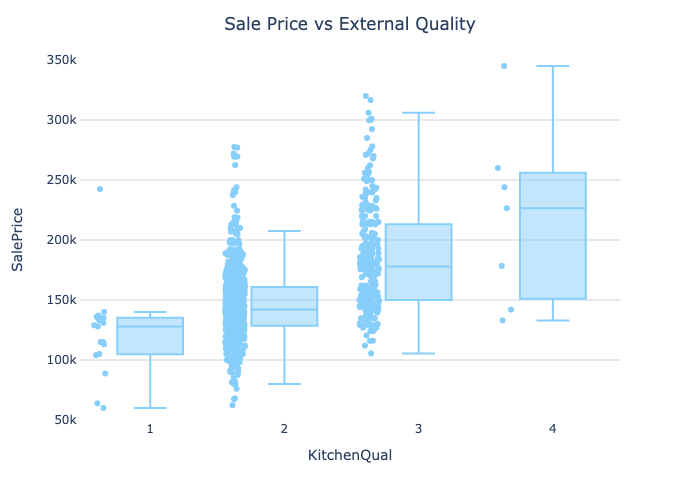

In [39]:
fig = px.box(
            data[data.Location==2], 
            x='KitchenQual', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray', range=[50000,350000])

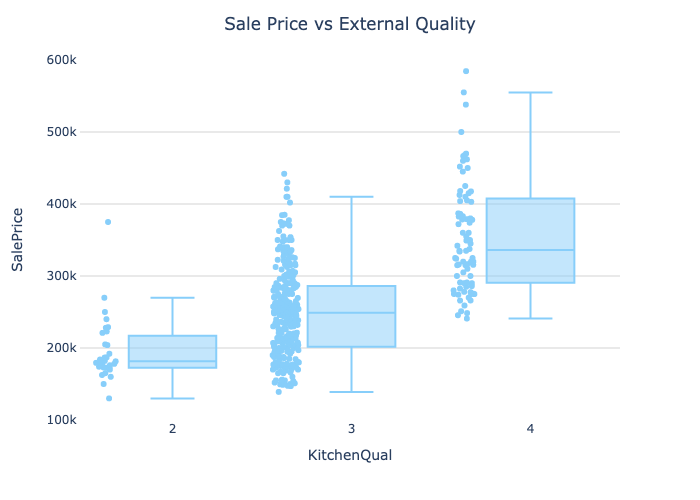

In [40]:
fig = px.box(
            data[data.Location==4], 
            x='KitchenQual', 
            y="SalePrice", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray', range=[100000,600000])

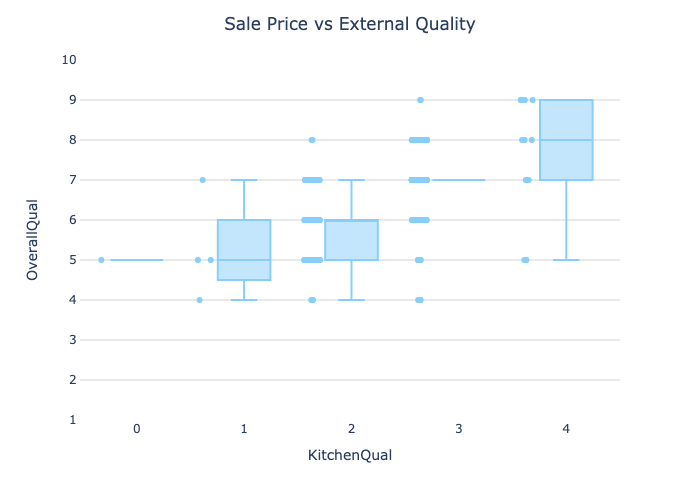

In [41]:
fig = px.box(
            data[data.Location==3], 
            x='KitchenQual', 
            y="OverallQual", 
            points="all")

fig.update_traces(marker_color = '#87CEFA')

fig.update_layout(title='Sale Price vs External Quality', title_x=0.5, showlegend=False, plot_bgcolor='white')

fig.update_xaxes(showline=False, gridcolor='white')
fig.update_yaxes(showline=True, gridcolor='lightgray', range=[1,10])

In [42]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for location in (1,2,3,4):

    temp = data[data.Location==location]

    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(temp, temp[['SalePrice']], test_size=0.30, random_state=42)


    scaler = StandardScaler()

    X_train_loc = X_train_loc.reset_index(drop=True)
    X_test_loc = X_test_loc.reset_index(drop=True)

    y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
    y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

    X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
    X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)
    X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

    model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass + Remod +\
                        BsmtUnfSF + Zone + Location +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        MasVnrArea + BsmtFinSF1 +\
                        GrLivArea:Fireplaces', 
                        data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

    results_fu = model.fit()

    n = X_train.shape[0]
    results_fr = model.fit_regularized(L1_wt=0, alpha=0.1/n, start_params=results_fu.params)

    test_params = np.round(results_fr.params, 6)
    test_params[0] = results_fu.params[0]

    final = sm.regression.linear_model.OLSResults(model, 
                                                test_params,
                                                model.normalized_cov_params)

    final.summary()
    yhat_train_loc = final.predict(X_train_scaled_loc)
    yhat_test_loc = final.predict(X_test_scaled_loc)

    train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
    test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

    print(train_rmse_non_log)
    print(test_rmse_non_log)


    df_train_loc = pd.DataFrame(np.concatenate((np.array(yhat_train_loc).reshape(-1,1), np.array(y_train_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_train = pd.concat([df_train, df_train_loc], axis=0)

    df_test_loc = pd.DataFrame(np.concatenate((np.array(yhat_test_loc).reshape(-1,1), np.array(y_test_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_test = pd.concat([df_test, df_test_loc], axis=0)

14954.282138738634
17807.216372587387
12333.294851409533
13900.258832862595
14309.735273188093
15396.119021024322
21186.927058697045
21791.434274738018


In [43]:
train_rmse_non_log = mean_squared_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

15135.339231671403
16692.10775956254


In [44]:
df_train = pd.DataFrame()
df_test = pd.DataFrame()

for largerhouse in (0,1):

    temp = data[data.LargerHouse==largerhouse]

    X_train_loc, X_test_loc, y_train_loc, y_test_loc = train_test_split(temp, temp[['SalePrice']], test_size=0.30, random_state=42)


    scaler = StandardScaler()

    X_train_loc = X_train_loc.reset_index(drop=True)
    X_test_loc = X_test_loc.reset_index(drop=True)

    y_train_loc = np.log(y_train_loc.reset_index(drop=True)['SalePrice'])
    y_test_loc = np.log(y_test_loc.reset_index(drop=True)['SalePrice'])

    X_train_scaled_loc = pd.DataFrame(scaler.fit_transform(X_train_loc[feature_selection]), columns=X_train_loc[feature_selection].columns)
    X_test_scaled_loc = pd.DataFrame(scaler.transform(X_test_loc[feature_selection]), columns=X_test_loc[feature_selection].columns)
    X_train_scaled_sm = sm.add_constant(X_train_scaled_loc)

    model = sm.OLS.from_formula('SalePrice ~  BsmtQual + OverallQual +\
                        GrLivArea + TotalBsmtSF  + GarageArea + FullBath + FlrSF1st + FlrSF2nd +\
                        HouseAge  + OverallCond + TotRmsAbvGrd + CentralAir +\
                        Fireplaces + LotArea + MSSubClass + Remod +\
                        BsmtUnfSF + Zone + Location +\
                        RemodAge + ExBsmtQual + RoadRail + KitchenQual + HalfBath + BedroomPerSF +\
                        MasVnrArea + BsmtFinSF1 +\
                        GrLivArea:Fireplaces', 
                        data=pd.concat([X_train_scaled_sm, y_train_loc], axis=1))

    results_fu = model.fit()

    n = X_train.shape[0]
    results_fr = model.fit_regularized(L1_wt=0, alpha=1.1/n, start_params=results_fu.params)

    test_params = np.round(results_fr.params, 6)
    test_params[0] = results_fu.params[0]

    final = sm.regression.linear_model.OLSResults(model, 
                                                test_params,
                                                model.normalized_cov_params)

    final.summary()
    yhat_train_loc = final.predict(X_train_scaled_loc)
    yhat_test_loc = final.predict(X_test_scaled_loc)

    train_rmse_non_log = mean_squared_error(np.exp(y_train_loc), np.exp(yhat_train_loc), squared=False)
    test_rmse_non_log = mean_squared_error(np.exp(y_test_loc), np.exp(yhat_test_loc), squared=False)

    print(train_rmse_non_log)
    print(test_rmse_non_log)


    df_train_loc = pd.DataFrame(np.concatenate((np.array(yhat_train_loc).reshape(-1,1), np.array(y_train_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_train = pd.concat([df_train, df_train_loc], axis=0)

    df_test_loc = pd.DataFrame(np.concatenate((np.array(yhat_test_loc).reshape(-1,1), np.array(y_test_loc).reshape(-1,1)), axis=1), 
                columns=['yhat_train', 'y_train'])
    df_test = pd.concat([df_test, df_test_loc], axis=0)

11835.603446883471
12730.606409277601
21313.106257558688
20721.16565142454


In [45]:
train_rmse_non_log = mean_squared_error(np.exp(df_train.y_train), np.exp(df_train.yhat_train), squared=False)
test_rmse_non_log = mean_squared_error(np.exp(df_test.y_train), np.exp(df_test.yhat_train), squared=False)

print(train_rmse_non_log)
print(test_rmse_non_log)

16831.821112738915
16847.480385952174
